<a href="https://colab.research.google.com/github/emmetorior/CN7030-/blob/main/FINAL_ALMOST_Multistock_Multifeature_Test_Classifier_from_original_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
!pip install pyspark pandas numpy

In [163]:
#spark.catalog.clearCache()

from pyspark.sql import SparkSession
# Importing package
from pyspark.sql.functions import (
    expr, col, lag, lead, window, stddev, mean, first, last, concat, lit,
    when, abs, isnan, count, dayofmonth, month, year, to_date, udf, abs as spark_abs
)

from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.sql.functions import udf
from math import sqrt
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [164]:

####
def load_stock_data(data_dir, pd, stock_lookup ):

    df_list = []
    for symbol, name in stock_lookup.items():
      file_path = f"{data_dir}/{symbol}.csv"
      try:
          df = pd.read_csv(file_path)
          print(f"Loading: {symbol}")
          # new column at index 0 (the first col)
          df.insert(0, "symbol", symbol)
          df_list.append(df)
          combined_df = pd.concat(df_list, ignore_index=True)
          df.reset_index()
      except FileNotFoundError:
            print(f"Oops: {symbol} not found...")

    return combined_df

#
stock_lookup = {
        "AAPL": "Apple Inc.",
        "NVDA": "NVIDIA Corp",
        "MSFT": "Microsoft",
        "AMZN": "Amazon",
        "QQQ" : "Invesco QQQ Trust",
        "AVGO": "Broadcom Inc.",
        "TSLA": "Tesla Inc.",
        "COST": "Costco Wholesale Corp",
        "NFLX": "Netflix Inc.",
        "GOOGL": "Alphabet Inc."
    }

data_dir = "/content/drive/MyDrive/stockarchive/full_history"
df = load_stock_data(data_dir, pd, stock_lookup )
df.head(34000)


Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005
...,...,...,...,...,...,...,...,...
33995,TSLA,2014-10-13,11268700,238.570007,238.960007,221.000000,224.589996,224.589996
33996,TSLA,2014-10-10,12888300,244.639999,245.889999,235.199997,236.910004,236.910004
33997,TSLA,2014-10-09,7361300,262.250000,265.540009,254.399994,257.010010,257.010010
33998,TSLA,2014-10-08,5055100,260.100006,262.880005,252.639999,259.279999,259.279999


Clean the Data

In [165]:
def clean_data(df, pd):
    df['date'] = pd.to_datetime(df['date'])
    #df.set_index('date', inplace=True)
    return df
clean_data(df, pd)


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005
...,...,...,...,...,...,...,...,...
52176,GOOGL,2004-08-25,9188600,52.532532,54.054054,51.991993,53.053055,53.053055
52177,GOOGL,2004-08-24,15247300,55.675674,55.855854,51.836838,52.487488,52.487488
52178,GOOGL,2004-08-23,18256100,55.430431,56.796795,54.579578,54.754753,54.754753
52179,GOOGL,2004-08-20,22834300,50.555557,54.594593,50.300301,54.209209,54.209209


Slice a dataframe so that it only contains info from the QQQ stock

In [166]:
df_qqq = df.loc[ (df['symbol'] == 'QQQ') ]
df_qqq.head()

,symbol,date,volume,open,high,low,close,adjclose
24444,QQQ,2020-07-02,31898400,253.020004,254.270004,251.710007,252.190002,252.190002
24445,QQQ,2020-07-01,34689200,247.639999,251.520004,247.080002,250.490005,250.490005
24446,QQQ,2020-06-30,38909200,242.770004,248.160004,242.580002,247.600006,247.600006
24447,QQQ,2020-06-29,34377800,239.970001,242.850006,237.350006,242.839996,242.839996
24448,QQQ,2020-06-26,52824600,245.779999,245.960007,239.679993,240.220001,240.220001


Set up Spark, and the Spark dataframe is created from the pandas one.

Then we add some additional column data such as the 9 Day moving average, the trading range, and the percentage that the stock has changed since the previous day.

In [167]:
# Create Spark Session
spark = SparkSession.builder.appName("CN7030 Assn 1 - Stock Price Classifier").getOrCreate()

df_qqq = spark.createDataFrame(df_qqq)

Set a few additional features calculated from the existing ones

In [169]:
# 2. Trading Range - daily price range for the stock
df_qqq = df_qqq.withColumn("Trading_Range", col("high") - col("low"))

# 3. Prev Close
df_qqq = df_qqq.withColumn("prev_close", lag("close").over(Window.orderBy("date")))

# 5. price_change_percentage
df_qqq = df_qqq.withColumn("price_change_percentage",
    (col("close") - col("prev_close")) / col("prev_close") * 100
)

Add some moving averages - 9 Day and 100 Day MA

In [170]:

windowSpec9Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-8, 0)
windowSpec100Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-99, 0)

# Calculate moving averages
df_qqq = df_qqq.withColumn("9_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec9Day))
df_qqq = df_qqq.withColumn("100_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec100Day))

# *row skipping solution from stackexchange
df_qqq = df_qqq.withColumn("row_id", F.row_number().over(Window.partitionBy("symbol").orderBy("date")))
df_qqq = df_qqq.filter(F.col("row_id") >= 100).drop("row_id")

Clean up any null values and skip the first few days, since we are using moving averages.


In [171]:
# drop nulls
df_qqq = df_qqq.na.drop()

df_qqq.show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.59375|  56.59375|   -0.27609055770292656| 57.11805555555556|54.419921875|
|   QQQ|1999-08-03 00:00:00|13005000|57.2109375|  57.21875|     55.25|56.0703125| 48.88999

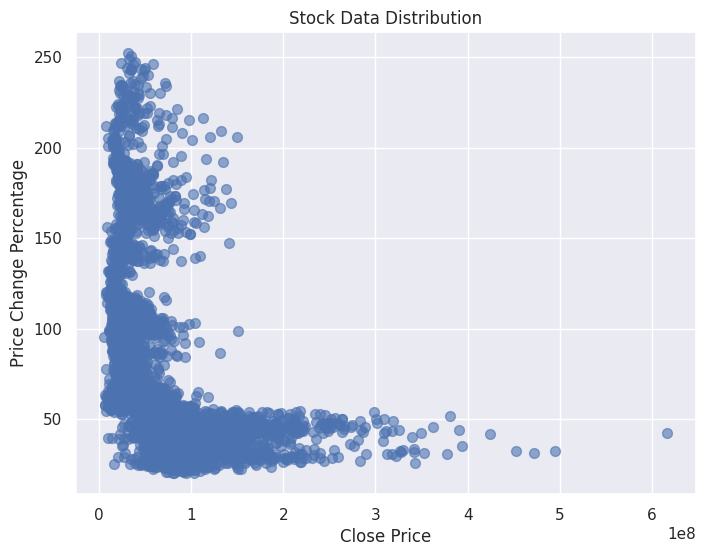

In [172]:
df_qqq_pd = df_qqq.toPandas()

# Visualize initial data distribution
plt.figure(figsize=(8, 6))
#plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.scatter(df_qqq_pd["volume"],df_qqq_pd["close"], s=50, alpha=0.6)
plt.title("Stock Data Distribution")
plt.xlabel("Close Price")
plt.ylabel("Price Change Percentage")
plt.show()

# **SET UP LABELS**

Populate the label column with values as follows:
Either Neutral, or Upward / Downward direction with a small, medium or large move, giving us NEUTRAL, DOWN_SMALL, DOWN_MEDIUM, DOWN_LARGE,  UP_SMALL, UP_MEDIUM, UP_LARGE

UP: +      DOWN: -
NEUTRAL: +- 0.3%
SMALL > 0.3% < 0.6
MEDIUM > 0.6% < 0.9%
LARGE > 0.9%

In [173]:
# Create label column derived from price change percentage and populate it
df_qqq = df_qqq.withColumn(
    "price_change_label", when(abs(col("price_change_percentage")) <= 0.3, "NEUTRAL")\
    .when((abs(col("price_change_percentage")) > 0.3) & (abs(col("price_change_percentage")) <= 0.6), "SMALL")\
    .when((abs(col("price_change_percentage")) > 0.6) & (abs(col("price_change_percentage")) <= 0.9), "MEDIUM")\
    .when(abs(col("price_change_percentage")) > 0.9, "LARGE")\
    .otherwise("NEUTRAL")  # Handle unexpected values
)

# Add "UP" or "DOWN" prefix based on the sign of price_change_percentage
df_qqq = df_qqq.withColumn(
    "price_change_label",
    when(col("price_change_percentage") > 0, concat(lit("UP-"), col("price_change_label")))
    .otherwise(concat(lit("DOWN-"), col("price_change_label")))
)

<em>Prepare features and vectorize this data </em>

In [174]:

feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','100_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
prepared_df = assembler.transform(df_qqq)
prepared_df.show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|price_change_label|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|        DOWN-SMALL|[57.125,56.59375,...|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.5937

In [175]:


# Convert label column to numerical indexes
label_indexer = StringIndexer(
    inputCol='price_change_label',
    outputCol='indexlabel'
)

# Check if 'indexlabel' column already exists
if 'indexlabel' not in prepared_df.columns:
    prepared_df = label_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("Column 'indexlabel' already exists. Skipping StringIndexer.")


In [176]:
# Split data
(train_data, test_data) = prepared_df.select('features', 'indexlabel').randomSplit([0.7, 0.3], seed=42)

# Train the Logistic Regression with max 10 iterations
lr = LogisticRegression(
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    labelCol='indexlabel',  # Make sure labelCol matches the outputCol of StringIndexer
    featuresCol='features'
)
model = lr.fit(train_data)

In [177]:
# Evaluate the model
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexlabel',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression: Model Accuracy: {accuracy} ")
print(f"{int(np.round(accuracy * 100))}%")

Logistic Regression: Model Accuracy: 0.35003295978905735 
35%


In [178]:

# Prepare features again
# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','100_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
#We need to redefine the df again
prepared_df = assembler.transform(df_qqq)
prepared_df.show()
# Convert label column to numerical indexes (remains the same)
label_indexer2 = StringIndexer(
    inputCol='price_change_label',
    outputCol='indexlabel2'
)

# Check if 'indexlabel2' column already exists (remains the same)
if 'indexlabel2' not in prepared_df.columns:
    prepared_df = label_indexer2.fit(prepared_df).transform(prepared_df)
else:
    print("already exists. Skipping.")

# Split data (remains the same)
(train_data, test_data) = prepared_df.select('features', 'indexlabel2').randomSplit([0.7, 0.3], seed=42)

# Train the Decision Tree Classifier
dt = DecisionTreeClassifier(
      #7 zones - auto detected I think in this version. numClasses=7
    maxDepth=5,  # Hyperparameter - fix this
    impurity="gini",  # Impurity
    seed=42,  #
    labelCol='indexlabel2', # Changed to use 'indexlabel2' as the label column
    featuresCol='features'
)
model = dt.fit(train_data)

# Evaluate the model (remains the same)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexlabel2',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator.evaluate(predictions)
print(f"Decision Tree: Model Accuracy: {accuracy} ")
print(f"{int(np.round(accuracy * 100))}%")

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|price_change_label|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|        DOWN-SMALL|[57.125,56.59375,...|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.5937

EVALUATE THE LABELS

In [179]:
#Prepare Features again #3
# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
prepared_df = assembler.transform(df_qqq)
prepared_df.show()
#-
# Convert label column to numerical indexes
label_indexer = StringIndexer(
    inputCol='price_change_label',
    outputCol='label'
)

# Check if 'indexlabel3' column already exists
if 'label' not in prepared_df.columns:
    prepared_df = label_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("Column 'label' already exists. Skipping StringIndexer.")
#-
# Split data
(train_data, test_data) = prepared_df.select('features', 'label').randomSplit([0.7, 0.3], seed=42)

#---------------------------------------------
# replace original columns here - like in the previous one. I just wrote this app with reduced features to make it easier to create.
prepared_df = prepared_df.withColumn('open', col('open')) \
    .withColumn('close', col('close')) \
    .withColumn('price_change_percentage', col('price_change_percentage'))
    #.withColumn('price_change_label', col('price_change_label'))

# Split into training and test sets
(train_data, test_data) = prepared_df.randomSplit([0.7, 0.3], seed=42)

# Training the log reg
lr = LogisticRegression(
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    labelCol='label',
    featuresCol='features'
)
model = lr.fit(train_data)

# predict
predictions = model.transform(test_data)
predictions.select('prediction').show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|price_change_label|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|        DOWN-SMALL|[57.125,56.59375,...|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.5937

In [180]:
# Define the mapping function
def map_prediction_to_label(prediction):
    temp = prediction
    pred = np.double(prediction)
    if (temp  < 0.3 ) and( temp >- 0.3):
      temp = "NEUTRAL"
    elif (temp>0.3):
      temp = "UP-"
    elif (temp<-0.3):
      temp = "DOWN-"

    tmpPred = np.abs(pred)

    if tmpPred < 0.3:
        tmpPredDesc = ''
    elif tmpPred < 0.6:
        tmpPredDesc = 'SMALL'
    elif tmpPred < 0.9:
        tmpPredDesc = 'MEDIUM'
    else:
        tmpPredDesc = 'LARGE'

    return temp + tmpPredDesc

# Register the function as a UDF
map_prediction_udf = udf(map_prediction_to_label, StringType())

# Use the UDF in the DataFrame
results_df = predictions.select(
    'open',
    'close',
    'price_change_percentage',
    'price_change_label',
    'prediction',
    map_prediction_udf(col('prediction')).alias('predicted_label')
)

# Display results
results_df.show()

+----------+----------+-----------------------+------------------+----------+---------------+
|      open|     close|price_change_percentage|price_change_label|prediction|predicted_label|
+----------+----------+-----------------------+------------------+----------+---------------+
|57.2109375|56.0703125|     -0.650609080841639|       DOWN-MEDIUM|       0.0|        NEUTRAL|
|  55.53125|54.6171875|    -1.2849477548715051|        DOWN-LARGE|       1.0|       UP-LARGE|
|  55.09375|  55.90625|     3.2909930715935336|          UP-LARGE|       0.0|        NEUTRAL|
|    56.125|     55.25|    -1.1738401341531581|        DOWN-LARGE|       1.0|       UP-LARGE|
|    58.125|     57.75|    -1.1235955056179776|        DOWN-LARGE|       1.0|       UP-LARGE|
|  57.21875|   57.0625|    -1.1904761904761905|        DOWN-LARGE|       1.0|       UP-LARGE|
|    57.125|  57.96875|     1.5881708652792992|          UP-LARGE|       0.0|        NEUTRAL|
|      61.5|60.4765625|    -1.6641260162601625|        DOWN-

CLUSTERING

# ***Cluster Problem ***

**Stock Price Segmentation**<br>
To segregate stocks from US market exchanges, such as Nasdaq - into distinct groups based on their price and volume data from the given standard stockprice history dataset along with certain additional fields that may be derived. Investigating if stocks may be clustered into groups from price movements and volume in a way that distinguishes between identifiable market segments and behaviour from which we may create a model to identify similar profiles of stock types.
This helps in creating a diverse portfolio, and to minimize risk.
This assignment takes a random sampling of 25 stocks.  
The basic features are as follows:
Open, high, low, close, volume and derived features include Daily Range, Price Change Percentage
Data is clean and preprocessed and null values dropped. The relevant features are chosen to be evaluated and over-correlated values omitted. The remaining data is normalized and passed to the algorithm. <p></p>
<strong>K Means clustering</strong> is used for cluster analysis. The silhouette coefficient calculates the similarity of each point to it’s cluster and thereby can calculate the effectiveness of the algorithm for this usage.
Assign Random points, and assign to nearest centroid. Recalculate

<strong>Silhouette Coefficient</strong>: Measures how similar a data point is to its own cluster compared to other clusters. A higher silhouette coefficient indicates better-defined cluster and repeat until maxIter is reached or convergence occurs.


In [182]:
stock_lookup = {
        "AAPL": "Apple Inc.",
        "NVDA": "NVIDIA Corp",
        "MSFT": "Microsoft",
        "AMZN": "Amazon",
        "QQQ" : "Invesco QQQ Trust",
        "AVGO": "Broadcom Inc.",
        "TSLA": "Tesla Inc.",
        "COST": "Costco Wholesale Corp",
        "NFLX": "Netflix Inc.",
        "GOOGL": "Alphabet Inc.",
        "GM"  :"General Motors Inc",
        "WMT":"Walmart",
        "RYAAY":"Ryanair",
        "MTSI" : "Macom Technologies"
    }



In [184]:
spark.catalog.clearCache() # Reset and clear cache and re-recreate spark session (due to corrupted caching issue on my computer)
spark = SparkSession.builder.appName("CN7030 Assn 1 - Stock Price Clustering").getOrCreate()


In [185]:
# Import KMeans from Scikit
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns;
import pickle
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
sns.set()  # styles for the chart

# Load all stocks in the current list
data_dir = "/content/drive/MyDrive/stockarchive/full_history"
stock_df = load_stock_data(data_dir, pd, stock_lookup)

stock_df.head() #pandas df

Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL
Loading: GM
Loading: WMT
Loading: RYAAY
Loading: MTSI


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005


In [186]:
stock_df = stock_df.dropna(how='all', axis=1)  #Drop nulls

In [188]:
stock_df['price_change_percentage'] = stock_df['close'].pct_change() * 100

stock_df = spark.createDataFrame(stock_df)  #convert to spark df


# Trading Range - daily price range for the stock
stock_df = stock_df.withColumn("Trading_Range", col("high") - col("low"))

# Prev Close
stock_df = stock_df.withColumn("prev_close", lag("close").over(Window.orderBy("date")))

# price_change_percentage
stock_df = stock_df.withColumn("price_change_percentage",
    (col("close") - col("prev_close")) / col("prev_close") * 100
)

In [189]:
# Create a Window specification partitioned by symbol and ordered by date
#make partition windows for lagging calculations.
w = Window.partitionBy("symbol").orderBy("date").rowsBetween(-1, -1)
stock_df = stock_df.withColumn("Monthly_Return", (col("close") - lag("close", 1).over(w)) / lag("close", 1).over(w) * 100 )
# Filter nulls
stock_df = stock_df.filter(col("Monthly_Return").isNotNull())
stock_df.show(500)

+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+--------------------+
|symbol|      date|  volume|              open|              high|               low|             close|          adjclose|price_change_percentage|       Trading_Range|  prev_close|      Monthly_Return|
+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+--------------------+
|  AAPL|1980-12-15|43971200|0.4888392984867096|0.4888392984867096|0.4866071343421936|0.4866071343421936|0.3845173120498657|     143.06619783727135|0.002232164144515991|0.2001953125|  -5.217394534942054|
|  AAPL|1980-12-16|26432000|          0.453125|          0.453125|0.4508928656578064|0.4508928656578064|0.3562958240509033|     126.33053648705577|0.002232134342193...|  0.19921875|  -7.33

In [193]:
#Calculate Volatility
stock_df = stock_df.withColumn("Volatility", stddev("Monthly_Return").over(Window.partitionBy("symbol").orderBy("date").rowsBetween(-30, 0)) * sqrt(12))

In [195]:

windowSpec9Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-8, 0)
windowSpec100Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-99, 0)

# Calculate moving averages
stock_df = stock_df.withColumn("9_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec9Day))
stock_df = stock_df.withColumn("100_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec100Day))

# *row skipping solution from stackexchange
stock_df = stock_df.withColumn("row_id", F.row_number().over(Window.partitionBy("symbol").orderBy("date")))
stock_df = stock_df.filter(F.col("row_id") >= 100).drop("row_id")

# Show the result
#stock_df_filtered.select("symbol", "date", "close", "9_Day_MA", "100_Day_MA").show(500)
#stock_df = stock_df[200:]

# drop nulls
stock_df = stock_df.na.drop()

stock_df.show()

+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+--------------+-------------+--------------------+------------------+-------------------+
|symbol|      date|  volume|              open|              high|               low|             close|          adjclose|price_change_percentage|       Trading_Range|  prev_close|Monthly_Return|30_Day_Return|          Volatility|          9_Day_MA|         100_Day_MA|
+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+--------------+-------------+--------------------+------------------+-------------------+
|  AAPL|1981-05-07| 2340800|0.4955357015132904|0.4977678656578064|0.4955357015132904|0.4955357015132904|0.3915725946426391|      63.68663172568044|0.002232164144515991| 0.302734375|  0.02

In [196]:

# Drop missing values if any, including those introduced by pct_change
stock_df = stock_df[["close", "volume", "Trading_Range", "9_Day_MA","100_Day_MA","price_change_percentage","Volatility", "Monthly_Return"]].dropna()

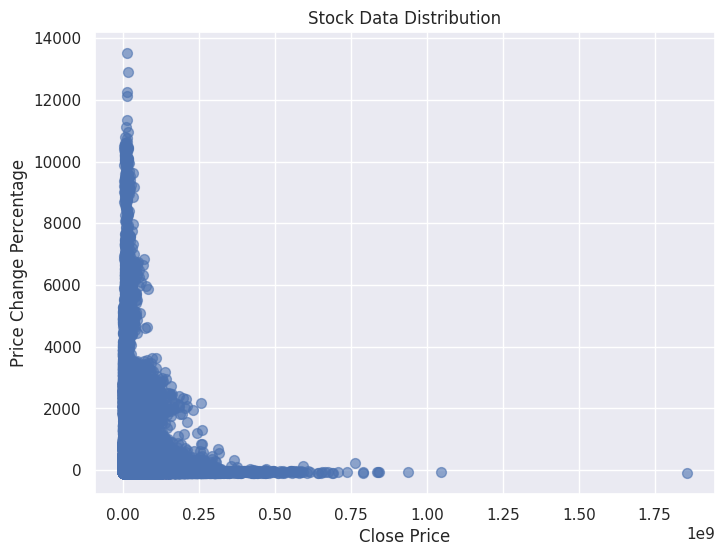

In [197]:
#convert back to pandas for the scatterplot
stock_df_pd = stock_df.toPandas()

# Visualize initial data distribution
plt.figure(figsize=(8, 6))
#plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.scatter(stock_df_pd["volume"], stock_df_pd["price_change_percentage"], s=50, alpha=0.6)
plt.title("Stock Data Distribution")
plt.xlabel("Close Price")
plt.ylabel("Price Change Percentage")
plt.show()

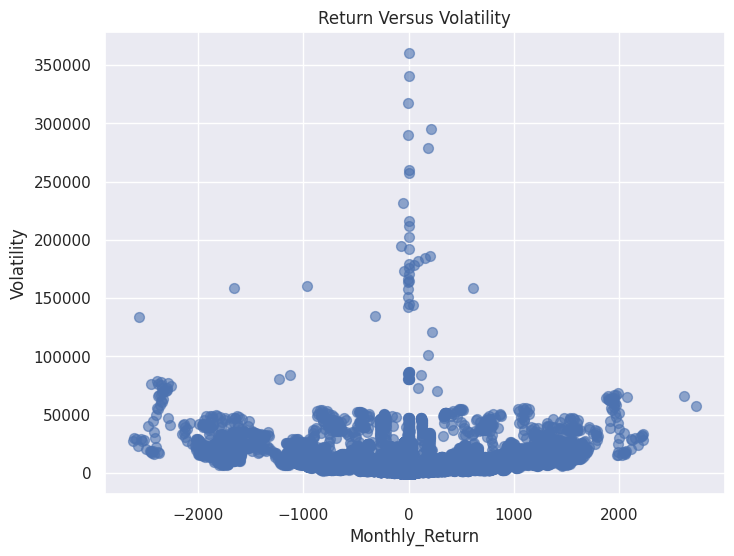

In [199]:
#convert back to pandas for the scatterplot
stock_df_pd = stock_df.toPandas()

# Visualize initial data distribution
plt.figure(figsize=(8, 6))
#plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.scatter(stock_df_pd["Monthly_Return"], stock_df_pd["Volatility"]*100, s=50, alpha=0.6)
plt.title("Return Versus Volatility")
plt.xlabel("Monthly_Return")
plt.ylabel("Volatility")
plt.show()

In [239]:
# Import the correct StandardScaler from PySpark (Scalar section from Apache Spark Docs)
from pyspark.ml.feature import StandardScaler

# Combine cols and create features
feature_cols =  ["close", "volume", "Trading_Range", "100_Day_MA", "price_change_percentage", "Volatility", "Monthly_Return"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(stock_df)
#scale

# Initialize StandardScaler with inputCol and outputCol
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
# Use assembled_df here to fit the scaler to your data
scalerModel = scaler.fit(assembled_df)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(assembled_df) # Use assembled_df to transform
scaledData.show()

+------------------+--------+--------------------+------------------+-------------------+-----------------------+--------------------+--------------+--------------------+--------------------+
|             close|  volume|       Trading_Range|          9_Day_MA|         100_Day_MA|price_change_percentage|          Volatility|Monthly_Return|            features|      scaledFeatures|
+------------------+--------+--------------------+------------------+-------------------+-----------------------+--------------------+--------------+--------------------+--------------------+
|0.4955357015132904| 2340800|0.002232164144515991|0.5022321343421936|0.49848214209079744|      63.68663172568044| 0.04153497043716571|  0.0244140625|[0.49553570151329...|[0.00211831663835...|
|               0.5| 1976800|0.002232134342193...|0.5007440381579928|0.49861607074737546|       69.5364238410596|0.041293104216493244|   0.013671875|[0.5,1976800.0,0....|[0.00213740062712...|
|0.4888392984867096| 2984800|0.002232134

In [245]:

# Transform the data
scaled_df = scalerModel.transform(assembled_df)  # Use assembled_df here

 #
# Convert the DataFrame back to Pandas for visualization
scaled_df_pd = scaled_df.toPandas()

In [248]:
scaled_df.show()

+------------------+--------+--------------------+------------------+-------------------+-----------------------+--------------------+--------------+--------------------+--------------------+
|             close|  volume|       Trading_Range|          9_Day_MA|         100_Day_MA|price_change_percentage|          Volatility|Monthly_Return|            features|      scaledFeatures|
+------------------+--------+--------------------+------------------+-------------------+-----------------------+--------------------+--------------+--------------------+--------------------+
|0.4955357015132904| 2340800|0.002232164144515991|0.5022321343421936|0.49848214209079744|      63.68663172568044| 0.04153497043716571|  0.0244140625|[0.49553570151329...|[0.00211831663835...|
|               0.5| 1976800|0.002232134342193...|0.5007440381579928|0.49861607074737546|       69.5364238410596|0.041293104216493244|   0.013671875|[0.5,1976800.0,0....|[0.00213740062712...|
|0.4888392984867096| 2984800|0.002232134

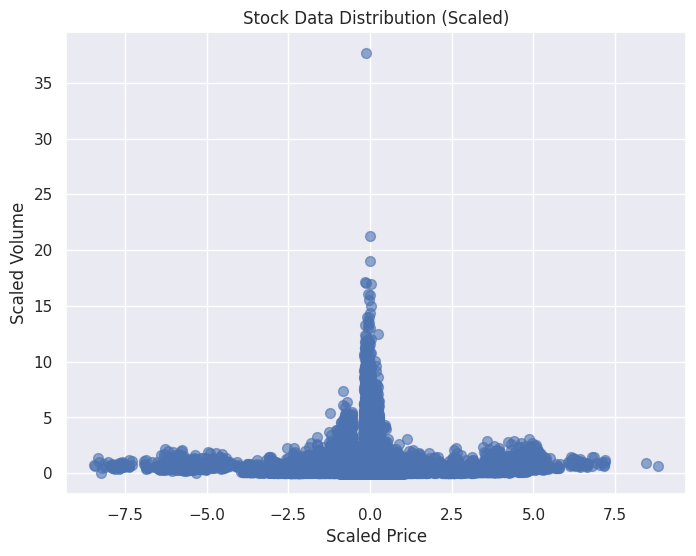

In [249]:

# Convert the DataFrame back to Pandas for visualization
scaled_df_pd = scaled_df.toPandas()

# Extract scaled features for plotting
# close|  volume|       Trading_Range|          9_Day_MA|         100_Day_MA|price_change_percentage|          Volatility|Monthly_Return|            features|      scaledFeatures
scaled_close = scaled_df_pd['scaledFeatures'].apply(lambda x: x.toArray()[0])
scaled_volume = scaled_df_pd['scaledFeatures'].apply(lambda x: x.toArray()[1])
scaled_volatility = scaled_df_pd['scaledFeatures'].apply(lambda x: x.toArray()[6])

# Visualize the scaled data
plt.figure(figsize=(8, 6))
plt.scatter(scaled_volatility, scaled_volume, s=50, alpha=0.6)  # Use extracted values
plt.title("Stock Data Distribution (Scaled)")
plt.xlabel("Scaled Price")
plt.ylabel("Scaled Volume")
plt.show()

**Returns vs Volume Chart**

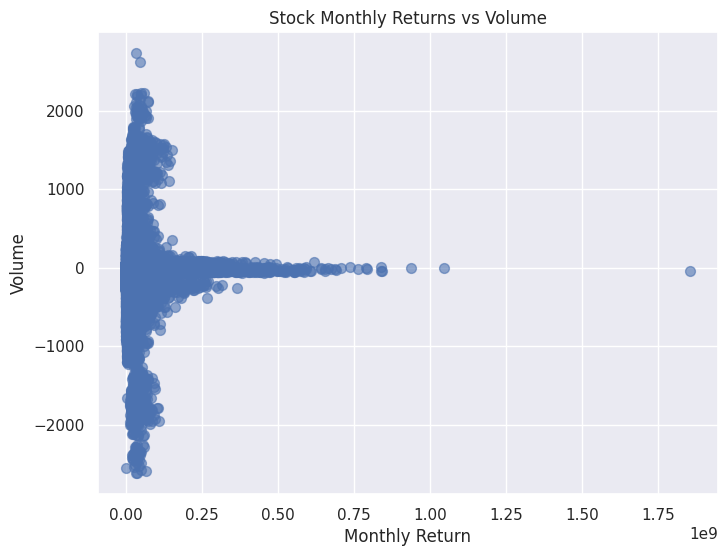

In [252]:
#new copy
stock_df_pd = stock_df.toPandas()

# Visualize initial data distribution
plt.figure(figsize=(8, 6))
#plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.scatter(stock_df_pd["volume"], stock_df_pd["Monthly_Return"], s=50, alpha=0.6)
plt.title("Stock Monthly Returns vs Volume")
plt.xlabel("Monthly Return")
plt.ylabel("Volume")
plt.show()

**Price To Volume Chart**

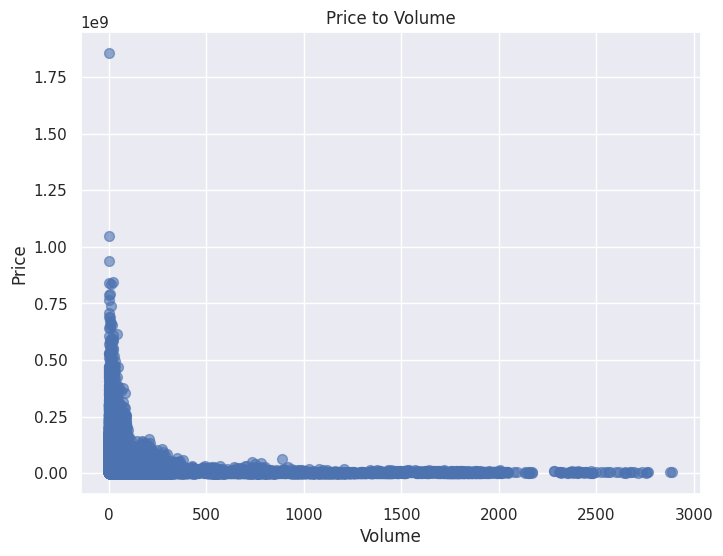

In [210]:

stock_df_pd = stock_df.toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(stock_df_pd["close"], stock_df_pd["volume"], s=50, alpha=0.6)
plt.title("Price to Volume")
plt.xlabel("Volume")
plt.ylabel("Price")
plt.show()

**K Means Model with initial parameters**<br>
These parameters appear to be too highly correlated to provide useful segmentations

Cluster Counts: {0: 10366, 1: 712, 2: 3782, 3: 41891, 4: 371, 5: 38, 6: 6970, 7: 2192, 8: 1, 9: 1245, 10: 139, 11: 5501}


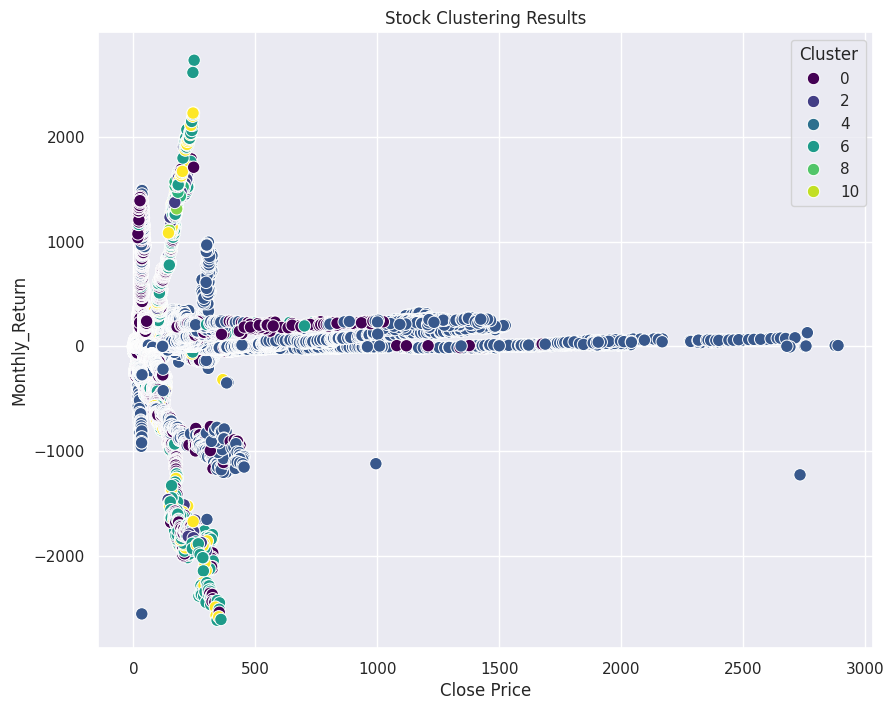

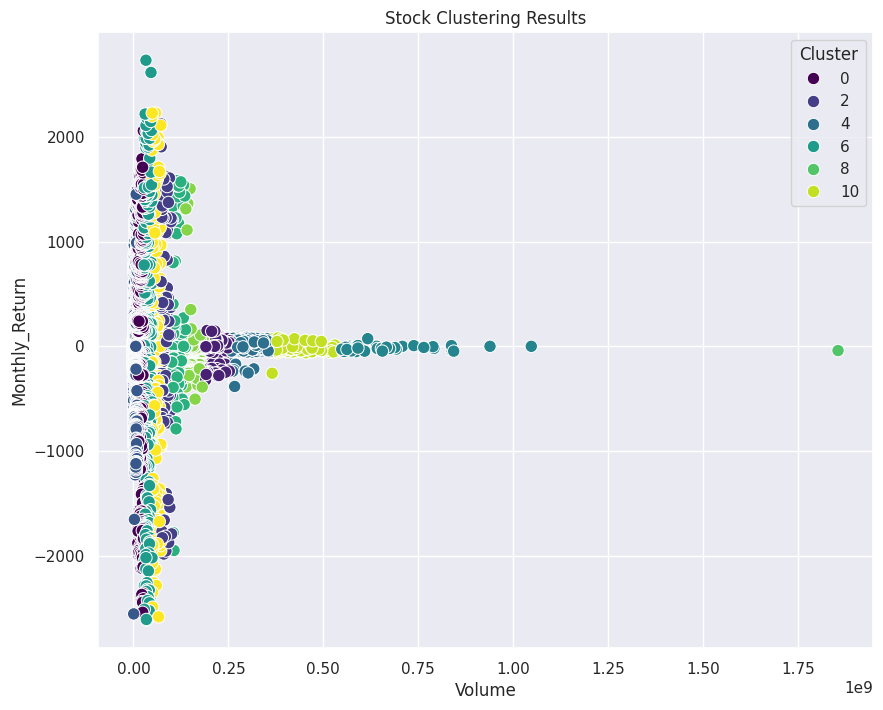

In [213]:
# Train model
model = KMeans(n_clusters=12, random_state=42)
model.fit(stock_df_pd)

# Save it and Load it again
pickle_filename = "kmeans_stock_model.pickle"
pickle.dump(model, open(pickle_filename, "wb"))
loaded_model = pickle.load(open(pickle_filename, "rb"))

# Get cluster labels and count (from the notes)
labels = loaded_model.labels_
unique_labels, label_counts = np.unique(labels, return_counts=True)

print("Cluster Count:", dict(zip(unique_labels, label_counts)))

# Add labels to DataFrame
stock_df_pd["Cluster"] = labels

#"volume", "Trading_Range", "9_Day_MA","100_Day_MA","price_change_percentage", "Monthly_Return"
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_df_pd["close"],
    y=stock_df_pd["Monthly_Return"],
    hue=stock_df_pd["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results")
plt.xlabel("Close Price")
plt.ylabel("Monthly_Return")
plt.show()


# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_df_pd["volume"],
    y=stock_df_pd["Monthly_Return"],
    hue=stock_df_pd["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results")
plt.xlabel("Volume")
plt.ylabel("Monthly_Return")
plt.show()


Train the model

Cluster Count: {0: 13379, 1: 216, 2: 1522, 3: 52344, 4: 5747}


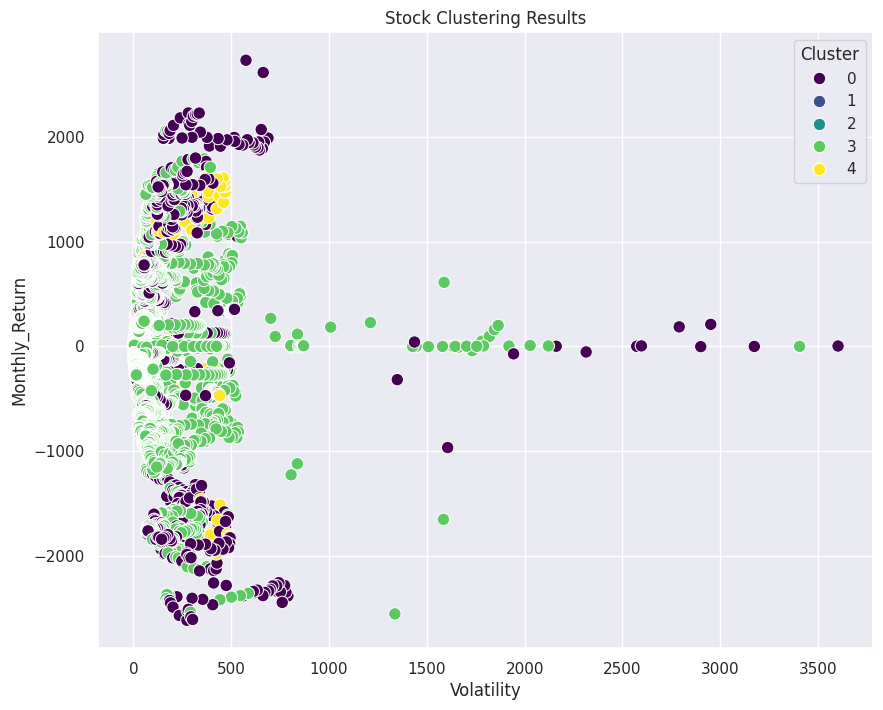

In [313]:
# Train model
model = KMeans(n_clusters=5, random_state=42)
model.fit(stock_df_pd)

# Save it and Load it again
pickle_filename = "kmeans_stock_model.pickle"
pickle.dump(model, open(pickle_filename, "wb"))
loaded_model = pickle.load(open(pickle_filename, "rb"))

# Get cluster labels and count (from the notes)
labels = loaded_model.labels_
unique_labels, label_counts = np.unique(labels, return_counts=True)

print("Cluster Count:", dict(zip(unique_labels, label_counts)))

# Add labels to DataFrame
stock_df_pd["Cluster"] = labels

#"volume", "Trading_Range", "9_Day_MA","100_Day_MA","price_change_percentage", "Monthly_Return"
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_df_pd["Volatility"],
    y=stock_df_pd["Monthly_Return"],
    hue=stock_df_pd["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results")
plt.xlabel("Volatility")
plt.ylabel("Monthly_Return")
plt.show()




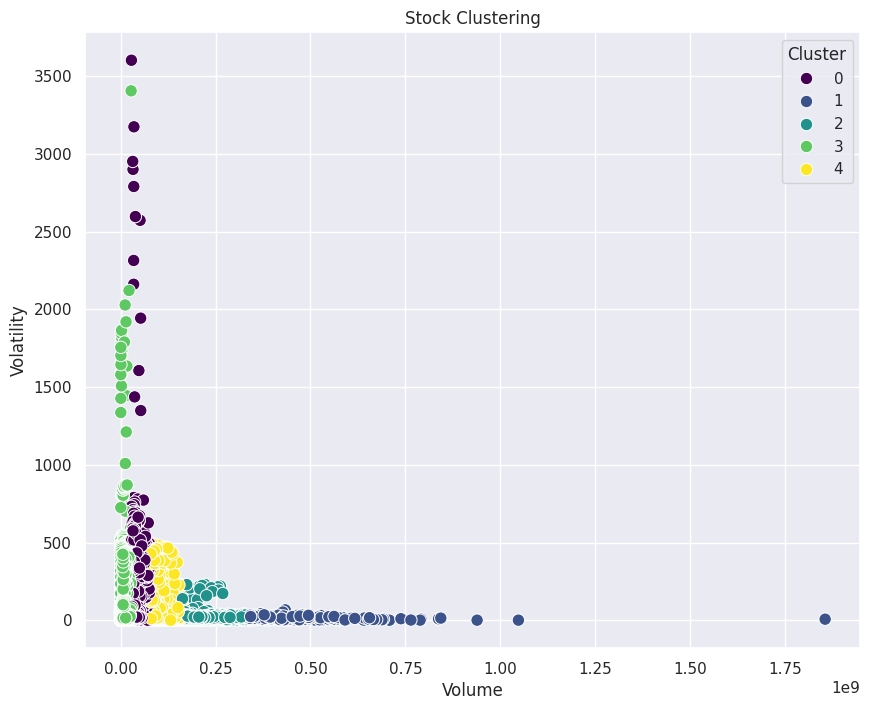

In [316]:

# Show clusters 2
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_df_pd["volume"],
    y=stock_df_pd["Volatility"],
    hue=stock_df_pd["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering")
plt.xlabel("Volume")
plt.ylabel("Volatility")
plt.show()

SILHOUETTE EVALUATION
Evaluations using the silhouette average score for K-Means Cluster.

In [301]:
#
#
stock_data['Cluster_RF'] = rf.predict(scaled_features)

# Evaluate with silhouette score (for K-Means)
silhouette_avg = silhouette_score(scaled_features, stock_data['Cluster_KMeans'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg:.2f}")


Silhouette Score for K-Means Clustering: 0.36


In [305]:
spark.catalog.clearCache() # Reset and clear cache and re-recreate spark session (due to corrupted caching issue on my computer)
spark = SparkSession.builder.appName("CN7030 Assn 1 - Stock Price Clustering").getOrCreate()

# Import KMeans from Scikit
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns;
import pickle
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
sns.set()  # styles for the chart
stock_lookup = {         "QQQ" : "Invesco QQQ Trust" }
# Load all stocks in the current list
data_dir = "/content/drive/MyDrive/stockarchive/full_history"
stock_df = load_stock_data(data_dir, pd, stock_lookup)

#stock_df.head() #pandas df
stock_df['date'] = pd.to_datetime(stock_df['date'])
df_qqq = stock_df.loc[ (stock_df['symbol'] == 'QQQ') ]
df_qqq.head()

Loading: QQQ


,symbol,date,volume,open,high,low,close,adjclose
0,QQQ,2020-07-02,31898400,253.020004,254.270004,251.710007,252.190002,252.190002
1,QQQ,2020-07-01,34689200,247.639999,251.520004,247.080002,250.490005,250.490005
2,QQQ,2020-06-30,38909200,242.770004,248.160004,242.580002,247.600006,247.600006
3,QQQ,2020-06-29,34377800,239.970001,242.850006,237.350006,242.839996,242.839996
4,QQQ,2020-06-26,52824600,245.779999,245.960007,239.679993,240.220001,240.220001


ALTERVATIVE CLUSTER ANALYSIS ON "QQQ", (NASDAQ INVESCO ETF)


In [317]:
import yfinance as yf        # i used this day 1..
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Fetch stock data and set moving averages (with pd this time)
ticker = 'QQQ'
df_qqq.dropna(inplace=True)
df_qqq['MA50'] = df_qqq['close'].rolling(window=50).mean()
df_qqq['MA20'] = df_qqq['close'].rolling(window=20).mean()

# Daily Percentage Move
df_qqq['Daily_Percent_Change'] = df_qqq['close'].pct_change() * 100

# Daily Price Range
df_qqq['Daily_Range'] = df_qqq['high'] - df_qqq['low']

# Skip the first few rows to avoid NaN values due to moving averages
 # Set up derived values for bollingers, moving averages
df_qqq['BB_upper'] = df_qqq['MA20'] + (2 * df_qqq['close'].rolling(window=20).std(ddof=0).values)
df_qqq['BB_lower'] = df_qqq['MA20'] - (2 * df_qqq['close'].rolling(window=20).std(ddof=0).values)
df_qqq['Daily_Percent_Change'] = df_qqq['close'].pct_change() * 100
df_qqq['volume'] = df_qqq['volume']

#df_qqq.dropna(inplace=True)
df_qqq = df_qqq.iloc[50:]

Stock data shape after cleaning: (5265, 17)


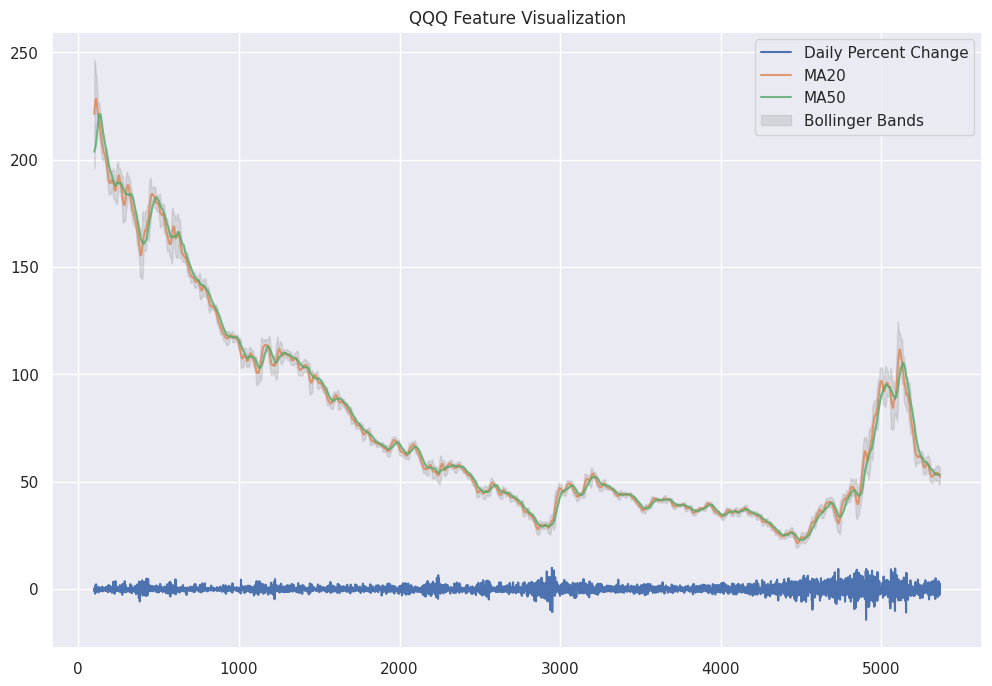

Silhouette Score for K-Means Clustering: 0.41


In [318]:
print(f"Stock data shape after cleaning: {df_qqq.shape}")
# Visualize the features
plt.figure(figsize=(12, 8))
plt.plot(df_qqq.index, df_qqq['Daily_Percent_Change'], label='Daily Percent Change')
#plt.plot(df_qqq.index, df_qqq['Volume'], label='Volume (scaled)', alpha=0.5)
plt.plot(df_qqq.index, df_qqq['MA20'], label='MA20', alpha=0.8)
plt.plot(df_qqq.index, df_qqq['MA50'], label='MA50', alpha=0.8)
plt.fill_between(df_qqq.index, df_qqq['BB_upper'], df_qqq['BB_lower'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.legend()
plt.title(f"{ticker} Feature Visualization")
plt.show()

# Prepare data for clustering
features = df_qqq[['Daily_Percent_Change', 'volume', 'MA20', 'MA50', 'BB_upper', 'BB_lower']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_qqq['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

#
df_qqq['Target'] = np.where(df_qqq['Daily_Percent_Change'] > 0, 1, 0)

# Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_features, df_qqq['Target'])

# predict
df_qqq['Cluster_RF'] = rf.predict(scaled_features)

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(scaled_features, df_qqq['Cluster_KMeans'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg:.2f}")




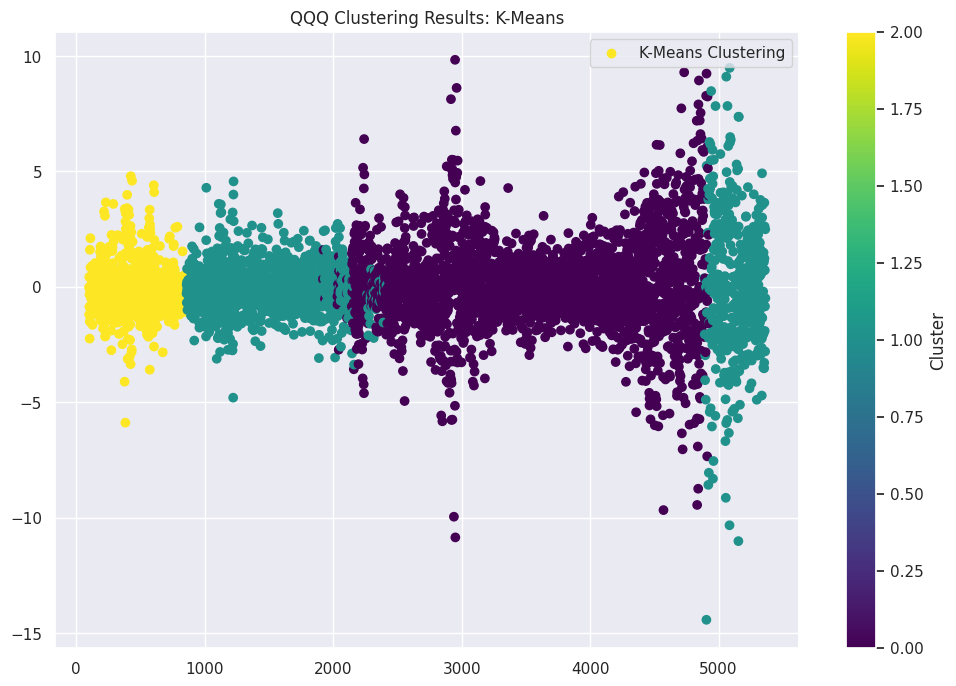

In [319]:
# Plot  clustering results
plt.figure(figsize=(12, 8))
plt.scatter(df_qqq.index, df_qqq['Daily_Percent_Change'], c=df_qqq['Cluster_KMeans'], cmap='viridis', label='K-Means Clustering')
plt.title(f"{ticker} Clustering Results: K-Means")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()




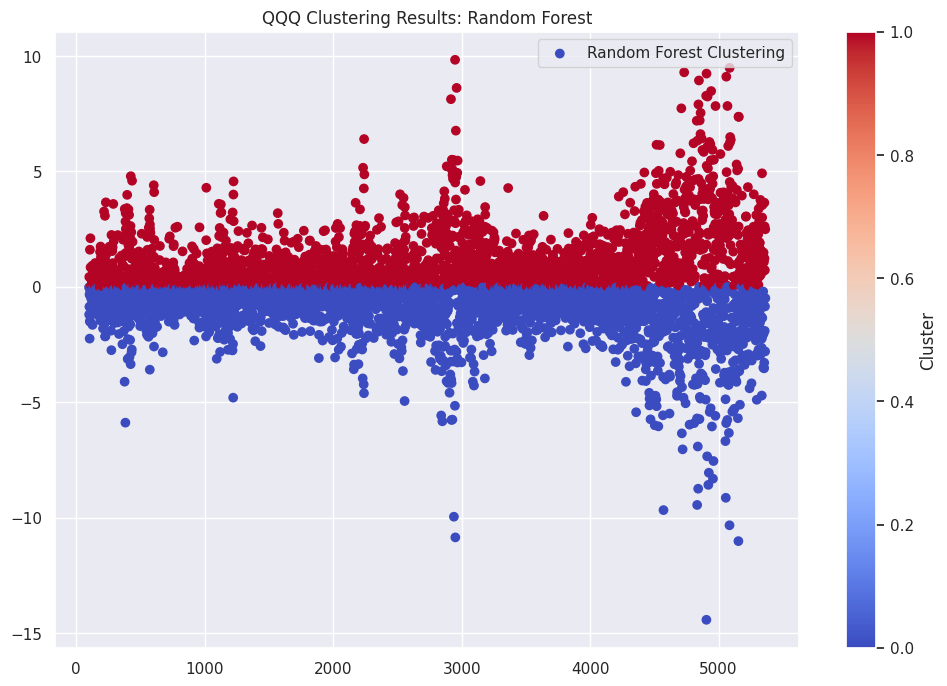

     Daily_Percent_Change  Cluster_KMeans  Cluster_RF
100             -0.017238               2           0
101             -1.194122               2           0
102              0.431940               2           1
103             -0.855815               2           0
104             -0.328630               2           0


In [320]:

plt.figure(figsize=(12, 8))
plt.scatter(df_qqq.index, df_qqq['Daily_Percent_Change'], c=df_qqq['Cluster_RF'], cmap='coolwarm', label='Random Forest Clustering')
plt.title(f"{ticker} Clustering Results: Random Forest")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

#
print(df_qqq[['Daily_Percent_Change', 'Cluster_KMeans', 'Cluster_RF']].head())